In [1]:
output_dir = "/JTE-607/Analysis/combined_backbones_mincov1_H1shortN4indel/Figure_4"

len(L3_APARENT_iso_pred_cut_nuc_scores) =  1908
len(L3_cleaved_input_enrichment) =  1908
correlation =  (0.6023068524473999, 9.410103137908027e-189)
correlation =  SpearmanrResult(correlation=0.5371039499339245, pvalue=4.625318805050055e-143)
len(SVLst_APARENT_iso_pred_cut_nuc_scores) =  1842
len(SVLst_cleaved_input_enrichment) =  1842
correlation =  (0.7213076922580727, 8.240366158051222e-296)
correlation =  SpearmanrResult(correlation=0.7149859787691527, pvalue=2.579911755208767e-288)


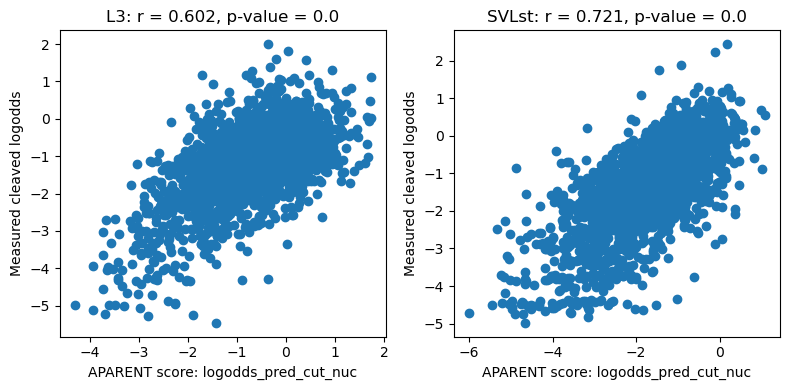

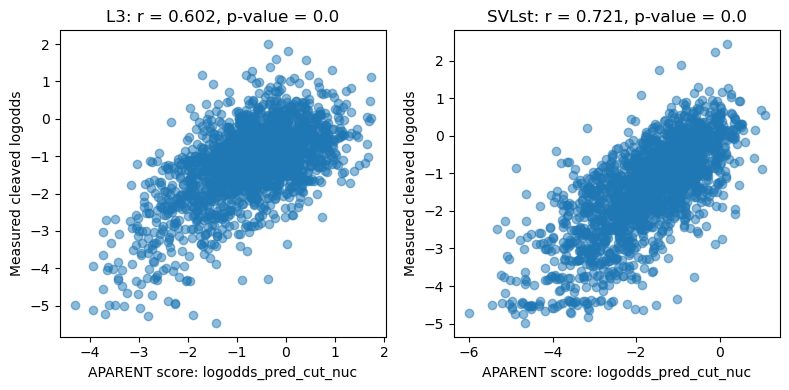

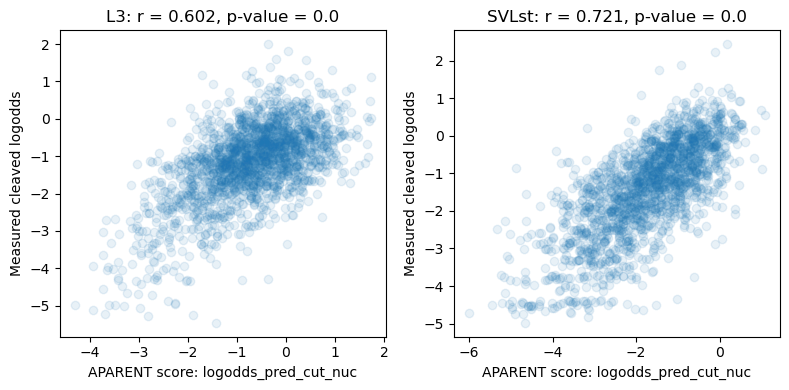

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import logit

# checking correlation between APARENT scores and input / DMSO reads
# calculating normalized input percentages, filtering for min coverage of 50 reads

def load_input_percentages(barcode_clusters_culled_file, min_cov=100):
    barcode_percents = {}
    with open(barcode_clusters_culled_file, "r") as f:
        f.readline()  # throw out header
        total_reads = 0
        for line in f:
            var = line.split("\t")
            barcode = var[0]
            coverage = float(var[2])
            total_reads += coverage
            if coverage >= min_cov:
                barcode_percents[barcode] = coverage

    for barcode, reads in barcode_percents.items():
        barcode_percents[barcode] = barcode_percents[barcode]/total_reads
    
    return barcode_percents


def load_DMSO_percentages_cutsite(PAS_read_counts_file, cut_site=46, min_cov=100):
    barcode_percents = {}
    with open(PAS_read_counts_file, "r") as f:
        total_reads = 0
        for line in f:
            var = line.split("\t")
            barcode = var[0]
            cut_pos = int(var[1])
            coverage = float(var[2])
            total_reads += coverage
            if coverage >= min_cov and cut_pos == cut_site:
                barcode_percents[barcode] = coverage

    for barcode, reads in barcode_percents.items():
        barcode_percents[barcode] = barcode_percents[barcode]/total_reads
    
    return barcode_percents


# L3 input
L3_barcode_clusters_culled_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/L3_input_barcode_clusters_consensus_seq_culled.txt"
L3_barcode_percents = load_input_percentages(L3_barcode_clusters_culled_file, min_cov=150)

# SVLst input
SVLst_barcode_clusters_culled_file = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/SVLst_input_barcode_clusters_consensus_seq_culled.txt"
SVLst_barcode_percents = load_input_percentages(SVLst_barcode_clusters_culled_file, min_cov=150)

# L3 DMSO
L3_DMSO_PAS_read_counts_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/L3_DMSO_polya_pos.txt"
L3_DMSO_barcode_percents = load_DMSO_percentages_cutsite(L3_DMSO_PAS_read_counts_file, cut_site=46, min_cov=1)

# SVLst DMSO
SVLst_DMSO_PAS_read_counts_file = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/SVLst_DMSO_polya_pos.txt"
SVLst_DMSO_barcode_percents = load_DMSO_percentages_cutsite(SVLst_DMSO_PAS_read_counts_file, cut_site=46, min_cov=1)

# Calculate estimated cleavage rate = DMSO % / input %
# L3 estimated cleavage rate
L3_cleaved_enrichment = {}
for PAS, input_percentage in L3_barcode_percents.items():
    if PAS in L3_DMSO_barcode_percents:
        p = L3_DMSO_barcode_percents[PAS] / (L3_DMSO_barcode_percents[PAS] + L3_barcode_percents[PAS])
        L3_cleaved_enrichment[PAS] = logit(p)
    #else:
    #    L3_cleaved_enrichment[PAS] = 0

# SVLst estimated cleavage rate
SVLst_cleaved_enrichment = {}
for PAS, input_percentage in SVLst_barcode_percents.items():
    if PAS in SVLst_DMSO_barcode_percents:
        p = SVLst_DMSO_barcode_percents[PAS] / (SVLst_DMSO_barcode_percents[PAS] + SVLst_barcode_percents[PAS])
        SVLst_cleaved_enrichment[PAS] = logit(p)
    #else:
    #    SVLst_cleaved_enrichment[PAS] = 0
# cleanup
del SVLst_DMSO_barcode_percents, SVLst_barcode_percents, L3_DMSO_barcode_percents, L3_barcode_percents

# parsing through APARENT scores
APARENT_score_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose/collapsed/all_DMSO_sequences_shifted_pred.csv"
APARENT_iso_pred_cut_nuc_scores = []
L3_APARENT_iso_pred_cut_nuc_scores = []
L3_cleaved_input_enrichment = []
SVLst_APARENT_iso_pred_cut_nuc_scores = []
SVLst_cleaved_input_enrichment = []

with open(APARENT_score_file, "r") as f:
    f.readline()  # throw out header
    for line in f:
        var = line.split("\t")
        sequence = var[0]
        iso_pred_cut_nuc = float(var[14])  # iso_pred_cut_nuc
        PAS = sequence[76:101]  # b/c shifted to same location in APARENT
        if sequence[:3] == "NNN":
            # L3 variant
            if PAS in L3_cleaved_enrichment:
                APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                L3_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                L3_cleaved_input_enrichment.append(L3_cleaved_enrichment[PAS])
        else:
            # SVLst variant
            if PAS in SVLst_cleaved_enrichment:
                APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                SVLst_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                SVLst_cleaved_input_enrichment.append(SVLst_cleaved_enrichment[PAS])

print("len(L3_APARENT_iso_pred_cut_nuc_scores) = ", len(L3_APARENT_iso_pred_cut_nuc_scores))
print("len(L3_cleaved_input_enrichment) = ", len(L3_cleaved_input_enrichment))

L3_correlation = stats.pearsonr(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment)
print("correlation = ", L3_correlation)
correlation = stats.spearmanr(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment)
print("correlation = ", correlation)

print("len(SVLst_APARENT_iso_pred_cut_nuc_scores) = ", len(SVLst_APARENT_iso_pred_cut_nuc_scores))
print("len(SVLst_cleaved_input_enrichment) = ", len(SVLst_cleaved_input_enrichment))

SVLst_correlation = stats.pearsonr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment)
print("correlation = ", SVLst_correlation)
correlation = stats.spearmanr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment)
print("correlation = ", correlation)

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment, 'o')
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment, 'o')
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured cleaved logodds")
ax[1].set_xlabel("APARENT score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment, 'o', alpha=0.5)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment, 'o', alpha=0.5)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured cleaved logodds")
ax[1].set_xlabel("APARENT score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/DMSO_input_cut46_mincov150_APARENT2_logodds_pred_cut_nuc_alpha0p5.pdf")
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment, 'o', alpha=0.1)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment, 'o', alpha=0.1)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured cleaved logodds")
ax[1].set_xlabel("APARENT score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/DMSO_input_cut46_mincov150_APARENT2_logodds_pred_cut_nuc_alpha0p1.pdf")
plt.show()

In [3]:
import pickle
from collections import defaultdict
import pandas as pd
from toolz import interleave

# Load JTE607 data from both backbones individually
# Filter based off of DMSO reads per variant
# Adds one to counts if there is a missing PAS from the list generated from DMSO. This is for log ratio.

# L3 loading and counting reads, filter away variants with < 50 reads in DMSO
#L3_shared_5p = "m"*5+"GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAATAATGTACTAGGAGACACTTTCAATAAA"
#L3_shared_3p = "TCGGGTGATTATTTACCCCCCACCCTTGCCGTCTGCGAGAATTCGAT"+"m"*14  #masking right end here to line up hexamer
parsed_L3_cleaved_output_dir = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_L3_DMSO_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_DMSO_polya_pos_dict.pickle"
polyA_L3_0p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_0p5uM_polya_pos_dict.pickle"
polyA_L3_2p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_2p5uM_polya_pos_dict.pickle"
polyA_L3_12p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_12p5uM_polya_pos_dict.pickle"

L3_polyA_pos_pickle_dict = {"L3_DMSO": polyA_L3_DMSO_cleaved_pickle,\
              "L3_0p5uM": polyA_L3_0p5uM_cleaved_pickle,\
             "L3_2p5uM": polyA_L3_2p5uM_cleaved_pickle,\
              "L3_12p5uM": polyA_L3_12p5uM_cleaved_pickle}

L3_PAS_read_counts = defaultdict(int)
polya_pos_dict = pickle.load(open(polyA_L3_DMSO_cleaved_pickle, "rb"))
data_name = "L3_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = curr_polya_pos_count_dict[46] if 46 in curr_polya_pos_count_dict else 0
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        L3_PAS_read_counts[curr_PAS] += curr_total_reads

# SVLst loading and counting reads, filter away variants with < 100 reads in DMSO
#SVLst_shared_5p = "GCGAATTGGAGCTCATGCTTTATTTGTGAAATTTGTGATGCTATTGCTTTATTTGTAACCATTATAAGCTGCAATAAA"
#SVLst_shared_3p = "ATTTTATGTTTCAGGTTCAGGGGGAGGTGTGGGAGGTTTTTTAAAGCAAGTAGAATTCGAT"
parsed_SVLst_cleaved_output_dir = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_SVLst_DMSO_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_polya_pos_dict.pickle"
polyA_SVLst_0p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_0p5uM_polya_pos_dict.pickle"
polyA_SVLst_2p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_2p5uM_polya_pos_dict.pickle"
polyA_SVLst_12p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_polya_pos_dict.pickle"

SVLst_polyA_pos_pickle_dict = {"SVLst_DMSO": polyA_SVLst_DMSO_cleaved_pickle,\
              "SVLst_0p5uM": polyA_SVLst_0p5uM_cleaved_pickle,\
             "SVLst_2p5uM": polyA_SVLst_2p5uM_cleaved_pickle,\
              "SVLst_12p5uM": polyA_SVLst_12p5uM_cleaved_pickle}

SVLst_PAS_read_counts = defaultdict(int)
SVLst_total_reads = 0
polya_pos_dict = pickle.load(open(polyA_SVLst_DMSO_cleaved_pickle, "rb"))
data_name = "SVLst_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = curr_polya_pos_count_dict[46] if 46 in curr_polya_pos_count_dict else 0
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        SVLst_PAS_read_counts[curr_PAS] += curr_total_reads

# combine L3 and SVLst, calculate percentages within each dataset
L3_PAS_percents_dict = {"L3_DMSO": None,\
              "L3_0p5uM": None,\
             "L3_2p5uM": None,\
              "L3_12p5uM": None}
SVLst_PAS_percents_dict = {"SVLst_DMSO": None,\
              "SVLst_0p5uM": None,\
             "SVLst_2p5uM": None,\
              "SVLst_12p5uM": None}

all_PAS = set()
for data_name, pickle_name in L3_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    if set(polya_pos_dict.keys()).intersection(set(L3_PAS_read_counts.keys())) != set(L3_PAS_read_counts.keys()):
        add_one = True
        for curr_PAS in set(L3_PAS_read_counts.keys()) - set(polya_pos_dict.keys()):
            PAS_read_counts[curr_PAS] += 1
    else:
        add_one = False
    print("%s add_one = %s" % (data_name, add_one))
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in L3_PAS_read_counts:
            curr_total_reads = curr_polya_pos_count_dict[46] if 46 in curr_polya_pos_count_dict else 0
            #curr_PAS = L3_shared_5p + curr_PAS + L3_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            if add_one:
                PAS_read_counts[curr_PAS] += 1
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    L3_PAS_percents_dict[data_name] = df

for data_name, pickle_name in SVLst_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    if set(polya_pos_dict.keys()).intersection(set(SVLst_PAS_read_counts.keys())) != set(SVLst_PAS_read_counts.keys()):
        add_one = True
        for curr_PAS in set(SVLst_PAS_read_counts.keys()) - set(polya_pos_dict.keys()):
            PAS_read_counts[curr_PAS] += 1
    else:
        add_one = False
    print("%s add_one = %s" % (data_name, add_one))
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in SVLst_PAS_read_counts:
            curr_total_reads = curr_polya_pos_count_dict[46] if 46 in curr_polya_pos_count_dict else 0
            #curr_PAS = SVLst_shared_5p + curr_PAS + SVLst_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            if add_one:
                PAS_read_counts[curr_PAS] += 1
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    SVLst_PAS_percents_dict[data_name] = df

print(len(all_PAS))

merged_PAS_percentage_L3 = None
for data_name, curr_df in L3_PAS_percents_dict.items():
    if merged_PAS_percentage_L3 is None:
        merged_PAS_percentage_L3 = curr_df
    else:
        merged_PAS_percentage_L3 = merged_PAS_percentage_L3.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.fillna(0)
print(merged_PAS_percentage_L3.shape)
print("Unsorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.set_index("PAS")
merged_PAS_percentage_L3.reset_index(level=0, inplace=True)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.sort_values(by=["DMSO_percent"], ascending=False)
print("Sorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)

# split into even and odd dataframes, and then merge together
merged_PAS_percentage_L3_odd = merged_PAS_percentage_L3.iloc[1::2]
merged_PAS_percentage_L3_even = merged_PAS_percentage_L3.iloc[::2]
merged_PAS_percentage_L3 = pd.concat([merged_PAS_percentage_L3_odd, merged_PAS_percentage_L3_even]).reset_index(drop=True)
print("Odd even merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)

merged_PAS_percentage_SVLst = None
for data_name, curr_df in SVLst_PAS_percents_dict.items():
    if merged_PAS_percentage_SVLst is None:
        merged_PAS_percentage_SVLst = curr_df
    else:
        merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.fillna(0)
print(merged_PAS_percentage_SVLst.shape)
#print("Unsorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.set_index("PAS")
merged_PAS_percentage_SVLst.reset_index(level=0, inplace=True)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.sort_values(by=["DMSO_percent"], ascending=False)
#print("Sorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)

# split into even and odd dataframes, and then merge together
merged_PAS_percentage_SVLst_odd = merged_PAS_percentage_SVLst.iloc[1::2]
merged_PAS_percentage_SVLst_even = merged_PAS_percentage_SVLst.iloc[::2]
merged_PAS_percentage_SVLst = pd.concat([merged_PAS_percentage_SVLst_odd, merged_PAS_percentage_SVLst_even]).reset_index(drop=True)
print("Odd even merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)

merged_PAS_percentage = pd.DataFrame(interleave([merged_PAS_percentage_L3.values, merged_PAS_percentage_SVLst.values]), \
                                     columns=merged_PAS_percentage_L3.columns)
print("Interleaved merged_PAS_percentage: ", merged_PAS_percentage)

del SVLst_PAS_percents_dict, L3_PAS_percents_dict, all_PAS, polya_pos_dict

L3_DMSO add_one = False
L3_0p5uM add_one = False
L3_2p5uM add_one = False
L3_12p5uM add_one = True
SVLst_DMSO add_one = False
SVLst_0p5uM add_one = False
SVLst_2p5uM add_one = False
SVLst_12p5uM add_one = False
138902
(88940, 5)
Unsorted merged_PAS_percentage_L3:                               PAS  DMSO_percent  0p5uM_percent  2p5uM_percent  \
0      GACTTCGGTGAGCAACGCGGGTCCG      0.000010       0.000007       0.000006   
1      GGTAGATTACGTCATTGTGTCTTTG      0.000015       0.000017       0.000016   
2      TGGTTGAACTGTCAAACTTGGTTTC      0.000011       0.000016       0.000017   
3      GTTTCGGCTTCTCATCCACTGTGGA      0.000008       0.000009       0.000007   
4      GGACTTAGCTGTCAGACTCATTGCG      0.000011       0.000013       0.000010   
...                          ...           ...            ...            ...   
88935  CGTCCTTAGGTCCAGTTGCGGACCT      0.000007       0.000010       0.000006   
88936  GATCCCACACTTTATAATGCTGTGT      0.000007       0.000009       0.000009   
88937  GGCGATGG

In [4]:
# need to avoid log(0)
zero_drug_plus_L3 = merged_PAS_percentage_L3[["12p5uM_percent"]]
zero_drug_plus_percent_L3 = zero_drug_plus_L3.div(merged_PAS_percentage_L3["DMSO_percent"]+merged_PAS_percentage_L3["12p5uM_percent"], axis=0)
zero_drug_plus_logit_L3 = logit(zero_drug_plus_percent_L3)
zero_drug_plus_logit_L3["PAS"] = merged_PAS_percentage_L3["PAS"]
zero_drug_plus_logit_L3.index = merged_PAS_percentage_L3["PAS"]

zero_drug_plus_SVLst = merged_PAS_percentage_SVLst[["12p5uM_percent"]]
zero_drug_plus_percent_SVLst = zero_drug_plus_SVLst.div(merged_PAS_percentage_SVLst["DMSO_percent"]+merged_PAS_percentage_SVLst["12p5uM_percent"], axis=0)
zero_drug_plus_logit_SVLst = logit(zero_drug_plus_percent_SVLst)
zero_drug_plus_logit_SVLst["PAS"] = merged_PAS_percentage_SVLst["PAS"]
zero_drug_plus_logit_SVLst.index = merged_PAS_percentage_SVLst["PAS"]


len(L3_APARENT_iso_pred_cut_nuc_scores) =  1065
len(L3_cleaved_drug_enrichment) =  1065
correlation =  (0.38000725548521164, 6.409522274152382e-38)
correlation =  SpearmanrResult(correlation=0.40660593144466933, pvalue=1.1559209004017107e-43)
len(SVLst_APARENT_iso_pred_cut_nuc_scores) =  548
len(SVLst_cleaved_drug_enrichment) =  548
correlation =  (0.2463617954191811, 5.086149385482389e-09)
correlation =  SpearmanrResult(correlation=0.23313070318863116, pvalue=3.366065231372803e-08)


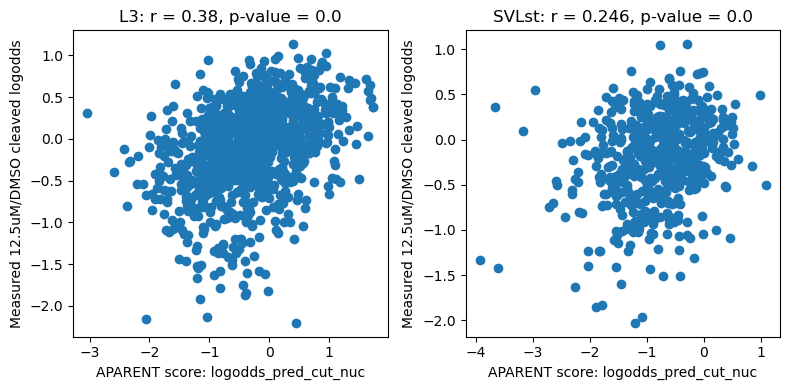

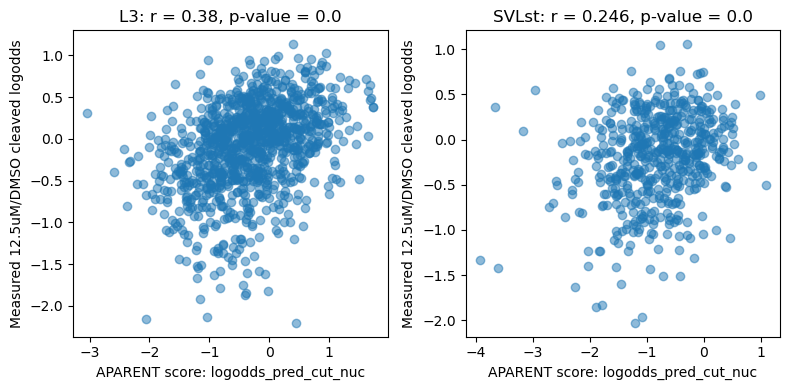

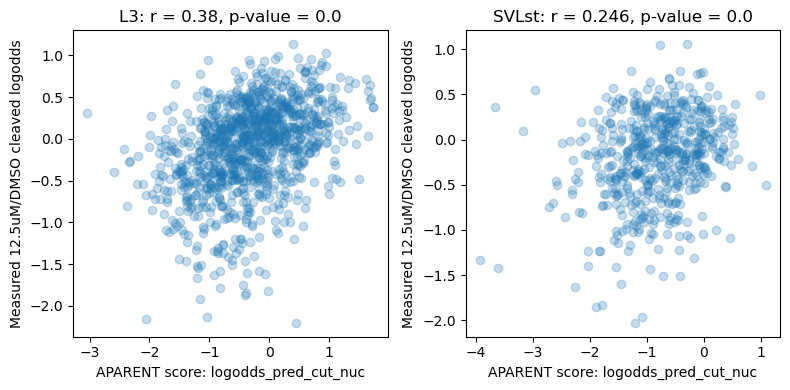

In [5]:
# parsing through APARENT scores
APARENT_score_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose/collapsed/all_DMSO_sequences_shifted_pred.csv"
APARENT_iso_pred_cut_nuc_scores = []
L3_APARENT_iso_pred_cut_nuc_scores = []
L3_cleaved_drug_enrichment = []
SVLst_APARENT_iso_pred_cut_nuc_scores = []
SVLst_cleaved_drug_enrichment = []

with open(APARENT_score_file, "r") as f:
    f.readline()  # throw out header
    for line in f:
        var = line.split("\t")
        sequence = var[0]
        iso_pred_cut_nuc = float(var[14])  # iso_pred_cut_nuc
        PAS = sequence[76:101]  # b/c shifted to same location in APARENT
        if sequence[:3] == "NNN":
            # L3 variant
            if PAS in L3_cleaved_enrichment:
                if PAS in zero_drug_plus_logit_L3.index:
                    APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                    L3_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                    L3_cleaved_drug_enrichment.append(zero_drug_plus_logit_L3.loc[PAS]["12p5uM_percent"])
        else:
            # SVLst variant
            if PAS in SVLst_cleaved_enrichment:
                if PAS in zero_drug_plus_logit_SVLst.index:
                    APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                    SVLst_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                    SVLst_cleaved_drug_enrichment.append(zero_drug_plus_logit_SVLst.loc[PAS]["12p5uM_percent"])

print("len(L3_APARENT_iso_pred_cut_nuc_scores) = ", len(L3_APARENT_iso_pred_cut_nuc_scores))
print("len(L3_cleaved_drug_enrichment) = ", len(L3_cleaved_drug_enrichment))

L3_correlation = stats.pearsonr(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_drug_enrichment)
print("correlation = ", L3_correlation)
correlation = stats.spearmanr(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_drug_enrichment)
print("correlation = ", correlation)

print("len(SVLst_APARENT_iso_pred_cut_nuc_scores) = ", len(SVLst_APARENT_iso_pred_cut_nuc_scores))
print("len(SVLst_cleaved_drug_enrichment) = ", len(SVLst_cleaved_drug_enrichment))

SVLst_correlation = stats.pearsonr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_drug_enrichment)
print("correlation = ", SVLst_correlation)
correlation = stats.spearmanr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_drug_enrichment)
print("correlation = ", correlation)

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_drug_enrichment, 'o')
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured 12.5uM/DMSO cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_drug_enrichment, 'o')
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured 12.5uM/DMSO cleaved logodds")
ax[1].set_xlabel("APARENT score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_drug_enrichment, 'o', alpha=0.5)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured 12.5uM/DMSO cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_drug_enrichment, 'o', alpha=0.5)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured 12.5uM/DMSO cleaved logodds")
ax[1].set_xlabel("APARENT score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/12p5uM_DMSO_cut46_mincov50_APARENT2_logodds_pred_cut_nuc_alpha0p5.pdf")
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_drug_enrichment, 'o', alpha=0.25)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured 12.5uM/DMSO cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_drug_enrichment, 'o', alpha=0.25)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured 12.5uM/DMSO cleaved logodds")
ax[1].set_xlabel("APARENT score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/12p5uM_DMSO_cut46_mincov50_APARENT2_logodds_pred_cut_nuc_alpha0p25.pdf")
plt.show()